In [55]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Specific to Google Colab
from google.colab import drive
drive.mount('/content/drive')

print(" Google Drive mounted and libraries loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted and libraries loaded.


In [56]:

# Load Data (Grayscale + 32x32)
import os
import cv2
import numpy as np
from tqdm import tqdm
basepath = '/content/drive/MyDrive/Animal Dataset'

def load_images(folder_path, label_id):
    images = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: Folder not found at {folder_path}")
        return [], []

    valid_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for filename in tqdm(valid_images, desc=f"Loading Label {label_id}"):
        img_path = os.path.join(folder_path, filename)

        img = cv2.imread(img_path)

        if img is not None:

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


            img = cv2.resize(img, (32, 32))


            img = img.flatten()

            images.append(img)
            labels.append(label_id)

    print(f"   Loaded {len(images)} images from {os.path.basename(folder_path)}")
    return images, labels


classes = ['cat', 'dog', 'panda']

X_data = []
y_data = []


if os.path.exists(basepath):
    print(f" Found dataset folder: {basepath}")
    print("--- Loading Dataset from Drive ---")

    for idx, class_name in enumerate(classes):
        folder_path = os.path.join(basepath, class_name)
        images, labels = load_images(folder_path, idx)
        X_data.extend(images)
        y_data.extend(labels)


    X = np.array(X_data)
    y = np.array(y_data)


    if len(X) > 0:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        print(f"\n Final Dataset Shape: {X.shape} (Should be N images x 1024 features)")
    else:
        print("\n No images loaded.")
        print("Please check that your subfolders are named 'cat', 'dog', and 'panda' inside 'Animal Dataset'.")

else:
    print(f"\n Could not find folder at: {basepath}")
    print("1. Go to your Google Drive.")
    print("2. Make sure you added the shortcut to 'My Drive'.")
    print("3. Ensure the folder name is exactly 'Animal Dataset' (Capital A, Capital D).")

✅ Found dataset folder: /content/drive/MyDrive/Animal Dataset
--- Loading Dataset from Drive ---


Loading Label 0: 100%|██████████| 100/100 [00:01<00:00, 89.31it/s]


   Loaded 100 images from cat


Loading Label 1: 100%|██████████| 100/100 [00:01<00:00, 93.27it/s]


   Loaded 100 images from dog


Loading Label 2: 100%|██████████| 100/100 [00:01<00:00, 66.86it/s]

   Loaded 100 images from panda

 Final Dataset Shape: (300, 1024) (Should be N images x 1024 features)


In [57]:

# Define Distances & KNN


def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def k_nearest_neighbors(X_train, y_train, x_query, k, distance_metric):
    distances = [(distance_metric(x_query, X_train[i]), y_train[i])
                 for i in range(len(X_train))]

    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    return max(set(k_labels), key=k_labels.count)

In [58]:

#  5-Fold Cross-Validation


num_folds = 5
k_values = range(1, 21)

if len(X) > 0:
    fold_indices = np.array_split(np.random.permutation(len(X)), num_folds)

    results = {'Euclidean': [], 'Manhattan': []}
    metrics = [('Euclidean', euclidean_distance), ('Manhattan', manhattan_distance)]

    for metric_name, metric_func in metrics:
        print(f"\nEvaluating {metric_name}...")
        metric_acc = []

        for k in tqdm(k_values, desc="Scanning K"):
            fold_accs = []

            for i in range(num_folds):
                val_idx = fold_indices[i]
                train_idx = np.hstack([fold_indices[j] for j in range(num_folds) if j != i])

                X_train, y_train = X[train_idx], y[train_idx]
                X_val, y_val = X[val_idx], y[val_idx]

                correct = 0

                for j in range(len(X_val)):
                    pred = k_nearest_neighbors(X_train, y_train,
                                               X_val[j], k, metric_func)
                    if pred == y_val[j]:
                        correct += 1

                fold_accs.append(correct / len(X_val))

            metric_acc.append(np.mean(fold_accs))

        results[metric_name] = metric_acc

    print("Cross-validation complete.")
else:
    print("Skipping CV as no data loaded.")


Evaluating Euclidean...


Scanning K: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]



Evaluating Manhattan...


Scanning K: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]

Cross-validation complete.


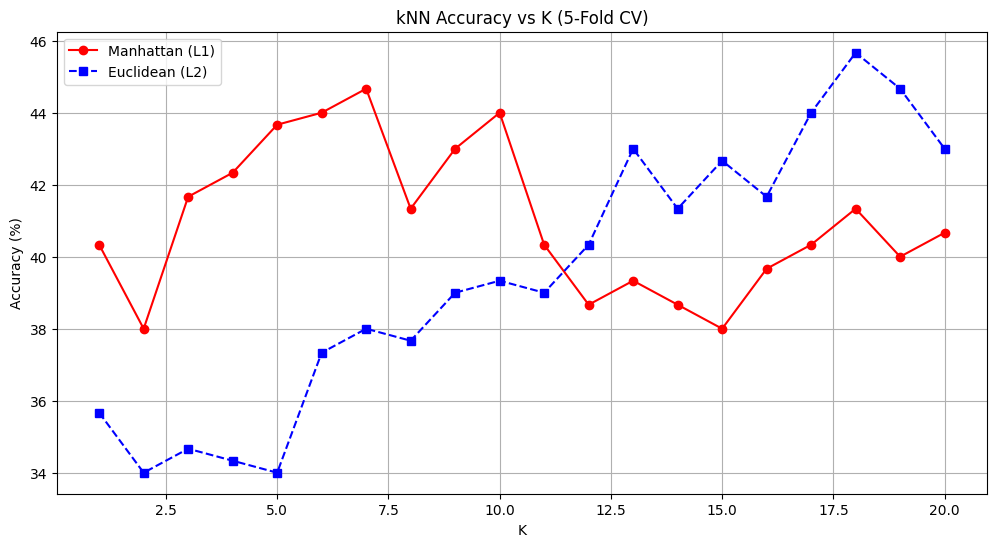


--- BEST RESULTS ---
L1 Manhattan Best:  44.67% at K=7
L2 Euclidean Best:  45.67% at K=18


In [59]:

# Visualization & Analysis


if len(X) > 0:
    plt.figure(figsize=(12,6))
    plt.plot(k_values, np.array(results['Manhattan']) * 100,
             marker='o', color='red', label='Manhattan (L1)')
    plt.plot(k_values, np.array(results['Euclidean']) * 100,
             marker='s', linestyle='--', color='blue', label='Euclidean (L2)')

    plt.title("kNN Accuracy vs K (5-Fold CV)")
    plt.xlabel("K")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Best results
    best_man = np.argmax(results['Manhattan'])
    best_euc = np.argmax(results['Euclidean'])

    print("\n--- BEST RESULTS ---")
    print(f"L1 Manhattan Best:  {results['Manhattan'][best_man]*100:.2f}% at K={k_values[best_man]}")
    print(f"L2 Euclidean Best:  {results['Euclidean'][best_euc]*100:.2f}% at K={k_values[best_euc]}")


Using Best Model → Euclidean (L2), K=18


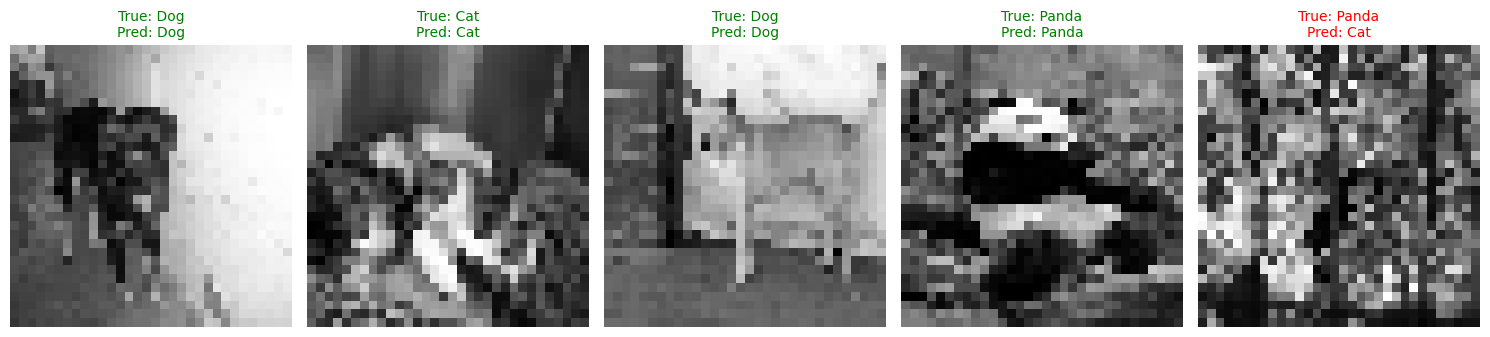

In [60]:

#Top 5 Predictions


if len(X) > 0:
    label_map = {0: "Cat", 1: "Dog", 2: "Panda"}


    if results['Manhattan'][best_man] > results['Euclidean'][best_euc]:
        chosen_metric = manhattan_distance
        chosen_name = "Manhattan (L1)"
        best_k = k_values[best_man]
    else:
        chosen_metric = euclidean_distance
        chosen_name = "Euclidean (L2)"
        best_k = k_values[best_euc]

    print(f"\nUsing Best Model → {chosen_name}, K={best_k}")

    random_ids = random.sample(range(len(X)), 5)
    plt.figure(figsize=(15, 4))

    for i, idx in enumerate(random_ids):
        test_img = X[idx]
        true = y[idx]

        X_train_tmp = np.delete(X, idx, axis=0)
        y_train_tmp = np.delete(y, idx, axis=0)

        pred = k_nearest_neighbors(X_train_tmp, y_train_tmp,
                                   test_img, best_k, chosen_metric)

        plt.subplot(1, 5, i+1)

        plt.imshow(test_img.reshape(32,32), cmap='gray')
        plt.title(f"True: {label_map[true]}\nPred: {label_map[pred]}",
                  color="green" if pred == true else "red", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()